In [51]:
import glob,os 
import librosa as rs
import numpy as np
import torch

import matplotlib.pyplot as plt   
from matplotlib import cm
import IPython.display as ipd
import json

In [9]:
path_json = "0.json"
path_noisy = "0.wav"
path_ref_1 = "0_1.wav"
path_ref_2 = "0_2.wav"

sr = 16000

In [10]:
with open(path_json,"r") as f : 
    label = json.load(f)

In [11]:
print(label.keys())

dict_keys(['pos_mic', 'n_src', 'RT60', 'room', 'traj_m', 'traj_s', 'SIRs', 'azimuth', 'elevation'])


In [37]:
label["pos_mic"]

[[-0.0191606632410728, 0.02091055204861029, 0.006888622197311412],
 [-0.011608297836313087, -0.016538209582423566, 0.007850731329076047],
 [0.02718607628243055, 0.020149492351855886, 0.009735062507576922],
 [0.02463540732010374, -0.01257059639344995, 0.006044077788924539]]

In [12]:
"""Angle Feauture
To get the angle feature, we first form the steering vector
for the direction-of-arrival (DOA) of each speaker. Then, the cosine
distance between the steering vector and the complex spectrum of
each channel that is normalized with respect to the first microphone 
is calculated as follows:

\begin{equation*}A_{n,tf} = \sum\limits_{i = 1}^M \frac{e_n^{i,f} \frac{y_{i,tf}}{y_{1,tf}}}{\left| e_n^{i,f} \frac{y_{i,tf}}{y_{1,tf}} \right|}\tag{2}\end{equation*}

where n is the speaker index, e^{i,f}_n is the steering vector coefficient
for speaker n’s DOA at microphone i and frequency bin f.

Intuitively, the angle feature lets the network to attend the sound coming
from the direction of a certain speaker. The idea of the angle feature
is similar to beamforming while it is different from the traditional
beamforming in that non-linear processing is performed with a neural network.

+ input
stft  : [C, F, T, 2(complex) ]
angle : [N(target), T, 2(azimuth,elevation)] 
mic_pos : [C,3]

+ return
AF : [N,C,F,T]
"""
def AngleFeature(stft,angle,mic_pos,fs=16000,complex=False,dist=1.0):
    # F : n_hfft
    C,F,T = stft.shape 
    N,_,_ = angle.shape

    ss = 340.3
    pi = 3.141592653589793
    n_fft = 2*F-2
    #n_fft = 2*F+1


    ## location of sources
    loc_src = torch.zeros(N,T,3)
    loc_src[:,:,0] = dist*torch.cos((90-angle[:,:,0])/180*pi)*torch.sin((90-angle[:,:,1])/180*pi)
    loc_src[:,:,1] = dist*torch.sin((90-angle[:,:,0])/180*pi)*torch.sin((90-angle[:,:,1])/180*pi)
    loc_src[:,:,2] = dist*torch.cos((90-angle[:,:,1])/180*pi)

    # TDOA
    TDOA = torch.zeros(N,C,T)

    for i in range(C) : 
        TDOA[:,i,:] = torch.norm(mic_pos[i,:] - loc_src[:,:,:] )

    ## Steering vector
    SV = torch.zeros(N,C,F,T, dtype=torch.cfloat)
    for i in range(F):
        SV[:,:,i,:] = torch.exp(-1j*2*pi*i/n_fft*TDOA*fs/ss)
        #[M] st(:,freq) = st(:,freq).*sqrt(nSensor/norm(st(:,freq)))

        # normalization per channel
        for i_N in range(N) : 
            for i_T in range(T) : 
                SV[i_N,:,i,i_T] = SV[i_N,:,i,i_T]/torch.sqrt((C)/torch.norm(SV[i_N,:,i,i_T]))
        #SV[:,:,i,:] = torch.exp(1j*2*pi*i/n_fft*TDOA*fs/ss)
    # norm

    """
    K. Tan, Y. Xu, S. Zhang, M. Yu and D. Yu, "Audio-Visual Speech Separation and Dereverberation With a Two-Stage Multimodal Network," in IEEE Journal of Selected Topics in Signal Processing, vol. 14, no. 3, pp. 542-553, March 2020, doi: 10.1109/JSTSP.2020.2987209.

    ... complex-valued, and they are treated as 2-D vectors in the operations < ·, · > and ||·||, where their real and imaginary parts are regarded as two vector  components.
    """

    ## Angle Feature
    if complex : 
        AF = torch.zeros(N,C,F,T, dtype=torch.cfloat)
        for i in range(N) : 
            tmp_term =  SV[i,:,:,:]*(stft[:,:,:]/stft[0:1,:,:])
            AF[i,:,:,:] = tmp_term/torch.abs(tmp_term)
        AF = torch.sum(AF,axis=1)
    else :
        ## real, imag as independent channel
        #AF = torch.zeros(2*N,C,F,T, dtype=torch.cfloat)
        #SV = torch.view_as_real(SV)
        #for i in range(N) : 
        #    tmp_stft = stft[:,:,:]/stft[0:1,:,:]
        #    tmp_stft = torch.view_as_real(tmp_stft)
        #    tmp_term = SV[i,:,:,:,:]*tmp_stft[:,:,:,:] 
        #    AF[2*i,:,:,:] = tmp_term[:,:,:,0]/torch.ans(tmp_term[:,:,:,0])
        #    AF[2*i+1,:,:,:] = tmp_term[:,:,:,1]/torch.ans(tmp_term[:,:,:,1])
        #AF = torch.sum(AF,axis=1)

        ## split real,imag in AF only
        AF = torch.zeros(N,C,F,T, dtype=torch.cfloat)
        for i in range(N) : 
            tmp_term =  SV[i,:,:,:]*(stft[:,:,:]/(stft[0:1,:,:]+1e-13))
            AF[i,:,:,:] = tmp_term/(torch.abs(tmp_term)+1e-13)
        AF = torch.sum(AF,axis=1)
        AF = torch.view_as_real(AF)                
        AF = torch.reshape(AF,(2*N,F,T))

    return AF

## Gen

In [70]:
angle_0 = np.stack((label["azimuth"][0],label["elevation"][0]),-1)
angle_1 = np.stack((label["azimuth"][1],label["elevation"][1]),-1)

angle_0 = torch.from_numpy(angle_0)
angle_0 = torch.unsqueeze(angle_0,0)
print(angle_0.shape)

angle_1 = torch.from_numpy(angle_1)
angle_1 = torch.unsqueeze(angle_1,0)

pos_mic = torch.tensor(label["pos_mic"])

torch.Size([1, 500, 2])


In [123]:
x = rs.load("0.wav",sr=sr,mono=False)[0]
X = rs.stft(x,n_fft=512)[:,:,:500]
X = torch.from_numpy(X)

x_0 = rs.load("0_0.wav",sr=sr,mono=False)[0]
X_0 = rs.stft(x_0,n_fft=512)[:,:,:500]
X_0 = torch.from_numpy(X_0)

x_1 = rs.load("0_1.wav",sr=sr,mono=False)[0]
X_1 = rs.stft(x_1,n_fft=512)[:,:,:500]
X_1 = torch.from_numpy(X_1)

print(x.shape)
print(X.shape)

AF_0 = AngleFeature(X,angle_0,pos_mic,fs=16000,complex=True,dist=100.0)
AF_1 = AngleFeature(X,angle_1,pos_mic,fs=16000,complex=True,dist=100.0)

AF_0_0 = AngleFeature(X_0,angle_0,pos_mic,fs=16000,complex=True,dist=100.0)
AF_1_1 = AngleFeature(X_1,angle_1,pos_mic,fs=16000,complex=True,dist=100.0)

AF_0_1 = AngleFeature(X_0,angle_1,pos_mic,fs=16000,complex=True,dist=100.0)
AF_1_0 = AngleFeature(X_1,angle_0,pos_mic,fs=16000,complex=True,dist=100.0)

(4, 64000)
torch.Size([4, 257, 500])


## AF

3.0603414
-3.0685065


Text(0, 0.5, 'Freq')

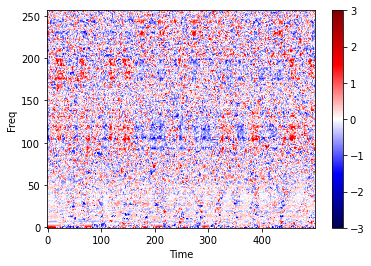

In [139]:
mag = np.abs(AF_0[0].numpy())
mag = mag[:,:] - np.mean(mag,axis=1)[:,np.newaxis]

im = plt.imshow(mag, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(-3,3)

print(np.max(mag))
print(np.min(mag))

plt.xlabel('Time')
plt.ylabel('Freq')

3.1033087
-3.0084946


Text(0, 0.5, 'Freq')

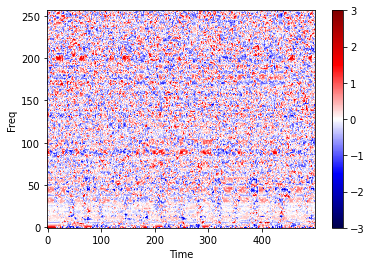

In [140]:
mag = np.abs(AF_1[0].numpy())
mag = mag[:,:] - np.mean(mag,axis=1)[:,np.newaxis]

im = plt.imshow(mag, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(-3,3)

print(np.max(mag))
print(np.min(mag))

plt.xlabel('Time')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

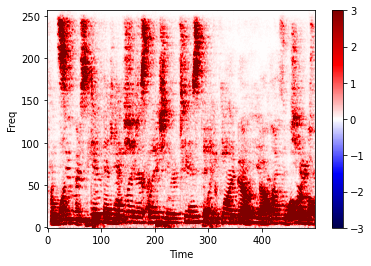

In [107]:
mag_d = np.abs(X[0].numpy())
im = plt.imshow(mag_d, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(-3,3)

plt.xlabel('Time')
plt.ylabel('Freq')

## Diff

Text(0, 0.5, 'Freq')

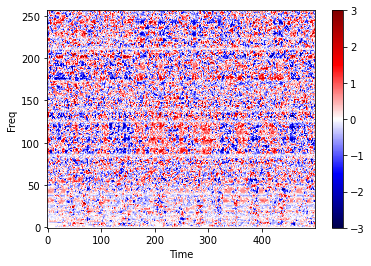

In [143]:
mag_0 = np.abs(AF_0[0].numpy())
mag_0 = mag_0[:,:] - np.mean(mag_0,axis=1)[:,np.newaxis]

mag_1 = np.abs(AF_1[0].numpy())
mag_1 = mag_1[:,:] - np.mean(mag_1,axis=1)[:,np.newaxis]

mag_d = mag_1 - mag_0
im = plt.imshow(mag_d, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(-3,3)

plt.xlabel('Time')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

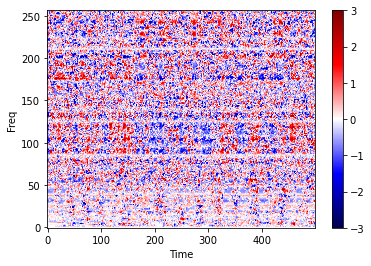

In [144]:
mag_0 = np.abs(AF_0[0].numpy())
mag_0 = mag_0[:,:] - np.mean(mag_0,axis=1)[:,np.newaxis]

mag_1 = np.abs(AF_1[0].numpy())
mag_1 = mag_1[:,:] - np.mean(mag_1,axis=1)[:,np.newaxis]

mag_d = mag_0 - mag_1
im = plt.imshow(mag_d, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(-3,3)

plt.xlabel('Time')
plt.ylabel('Freq')

## Clean

Text(0, 0.5, 'Freq')

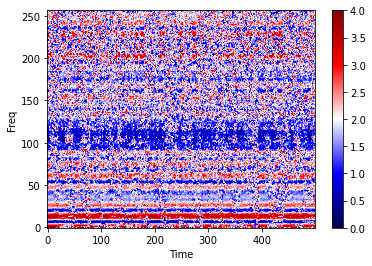

In [111]:
mag_1 = np.abs(AF_0_0[0].numpy())
im = plt.imshow(mag_1, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(0,4)

plt.xlabel('Time')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

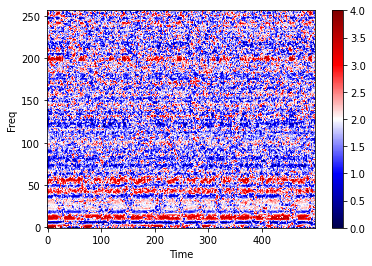

In [112]:
mag_1 = np.abs(AF_1_1[0].numpy())
im = plt.imshow(mag_1, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(0,4)

plt.xlabel('Time')
plt.ylabel('Freq')

## Cross

Text(0, 0.5, 'Freq')

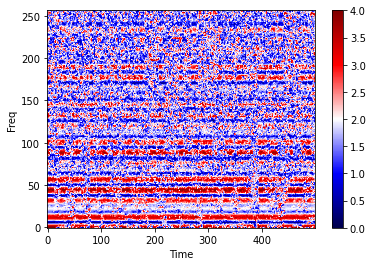

In [114]:
mag = np.abs(AF_0_1[0].numpy())
im = plt.imshow(mag, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(0,4)

plt.xlabel('Time')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

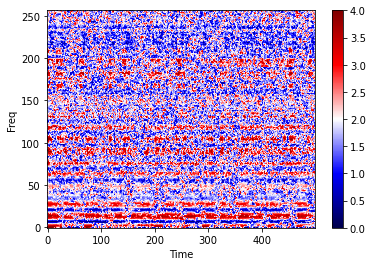

In [115]:
mag = np.abs(AF_1_0[0].numpy())
im = plt.imshow(mag, cmap=cm.seismic, aspect='auto',origin='lower')
plt.colorbar(im)
plt.clim(0,4)

plt.xlabel('Time')
plt.ylabel('Freq')

In [ ]:
ipd.display(ipd.Markdown('## input'))
ipd.display(ipd.Audio(x, rate=sr))

plt.figure()
plt.plot(x)
plt.title("x")